In [1]:
import datetime
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from emoji import get_emoji_regexp
from nltk.sentiment import SentimentIntensityAnalyzer
from random import shuffle
from sklearn import preprocessing
from time import strptime
from wordcloud import WordCloud, STOPWORDS

# Import data
reddit = pd.read_csv('./Datasets/reddit_wsb.csv')

# Data cleaning functions
emoji_pattern = get_emoji_regexp()

def remove_emojis(text):
    return re.sub(emoji_pattern, '', text)

def remove_punctuations(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def remove_tags(text):
    return re.sub('@[\w]*', '', text)

def remove_URLs(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))', '', text)

# Extract out relevant data - the thread title and timestamp only
reddit = reddit[['title', 'timestamp']]

# Data Cleaning
reddit['title'] = reddit['title'].str.lower()
reddit['title'] = reddit['title'].apply(lambda x: remove_emojis(x))
reddit['title'] = reddit['title'].apply(lambda x: remove_URLs(x))
reddit['title'] = reddit['title'].apply(lambda x: remove_tags(x))
reddit['title'] = reddit['title'].apply(lambda x: remove_punctuations(x))
reddit['title'] = reddit['title'].apply(lambda x: x.strip()) # Removes leading and trailing whitespaces

# Change Timestamp to date format
reddit['timestamp'] = pd.to_datetime(reddit['timestamp']).dt.date
reddit.rename(columns = {'timestamp': 'date'}, inplace = True)

# Removes any rows with dates outside of 2021
reddit = reddit[reddit['date'] >= datetime.date(2021, 1, 1)]

# Removes rows with empty titles
reddit = reddit[reddit['title'] != '']

# Resets row index
reddit = reddit.reset_index(drop = True)

In [2]:
reddit

,title,date
0,its not about the money its about sending a me...,2021-01-28
1,math professor scott steiner says the numbers ...,2021-01-28
2,exit the system,2021-01-28
3,new sec filing for gme can someone less retard...,2021-01-28
4,not to distract from gme just thought our amc ...,2021-01-28
...,...,...
53016,what i learned investigating sava fud spreaders,2021-08-02
53017,daily popular tickers thread for august 02 202...,2021-08-02
53018,hitler reacts to the market being irrational,2021-08-02
53019,daily discussion thread for august 02 2021,2021-08-02


In [3]:
# Filter out relevant words => did not filter out specific words since all from a specialised thread

# Conducting sentiment analysis using VADER model 
sia = SentimentIntensityAnalyzer()

reddit['negative'] = 0
reddit['positive'] = 0
reddit['neutral'] = 0
reddit['compound'] = 0
reddit['sentiment'] = 0

for i in range(len(reddit['title'])):
    sentence = reddit['title'][i]
    scores = sia.polarity_scores(sentence)
    
    reddit.loc[i, 'negative'] = scores.get('neg')
    reddit.loc[i, 'positive'] = scores.get('pos')
    reddit.loc[i, 'neutral'] = scores.get('neu')
    reddit.loc[i, 'compound'] = scores.get('compound')

    if scores.get('compound') > 0: 
        reddit.loc[i, 'sentiment'] = 1
    elif scores.get('compound') == 0: 
        reddit.loc[i, 'sentiment'] = 0
    else: 
        reddit.loc[i, 'sentiment'] = -1


In [4]:
# Creates a dataframe with aggregated values grouped by dates
reddit_daily = reddit.groupby(['date'])['compound'].agg(count = 'count', average = lambda x: x.sum() / x.count())

# Resets row index
reddit_daily = reddit_daily.reset_index()

# Export daily aggregated data to csv
reddit_daily.to_csv("./Datasets/reddit_wsb_daily.csv", index = False)

reddit_daily

,date,count,average
0,2021-01-28,1192,-0.007051
1,2021-01-29,15653,-0.014411
2,2021-01-30,1422,0.036902
3,2021-01-31,937,0.039319
4,2021-02-01,880,0.037553
...,...,...,...
171,2021-08-12,75,0.074153
172,2021-08-13,64,0.069134
173,2021-08-14,37,-0.028578
174,2021-08-15,21,0.020481


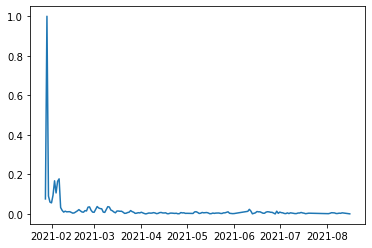

In [5]:
def normalize_data(df):
    minimum = min(df)
    maximum = max(df)
    x = df
    y = (x - minimum) / (maximum  - minimum)
    return y

x = reddit_daily['date']

avg = normalize_data(reddit_daily['average'])
count = normalize_data(reddit_daily['count'])

plt.plot(x, count)

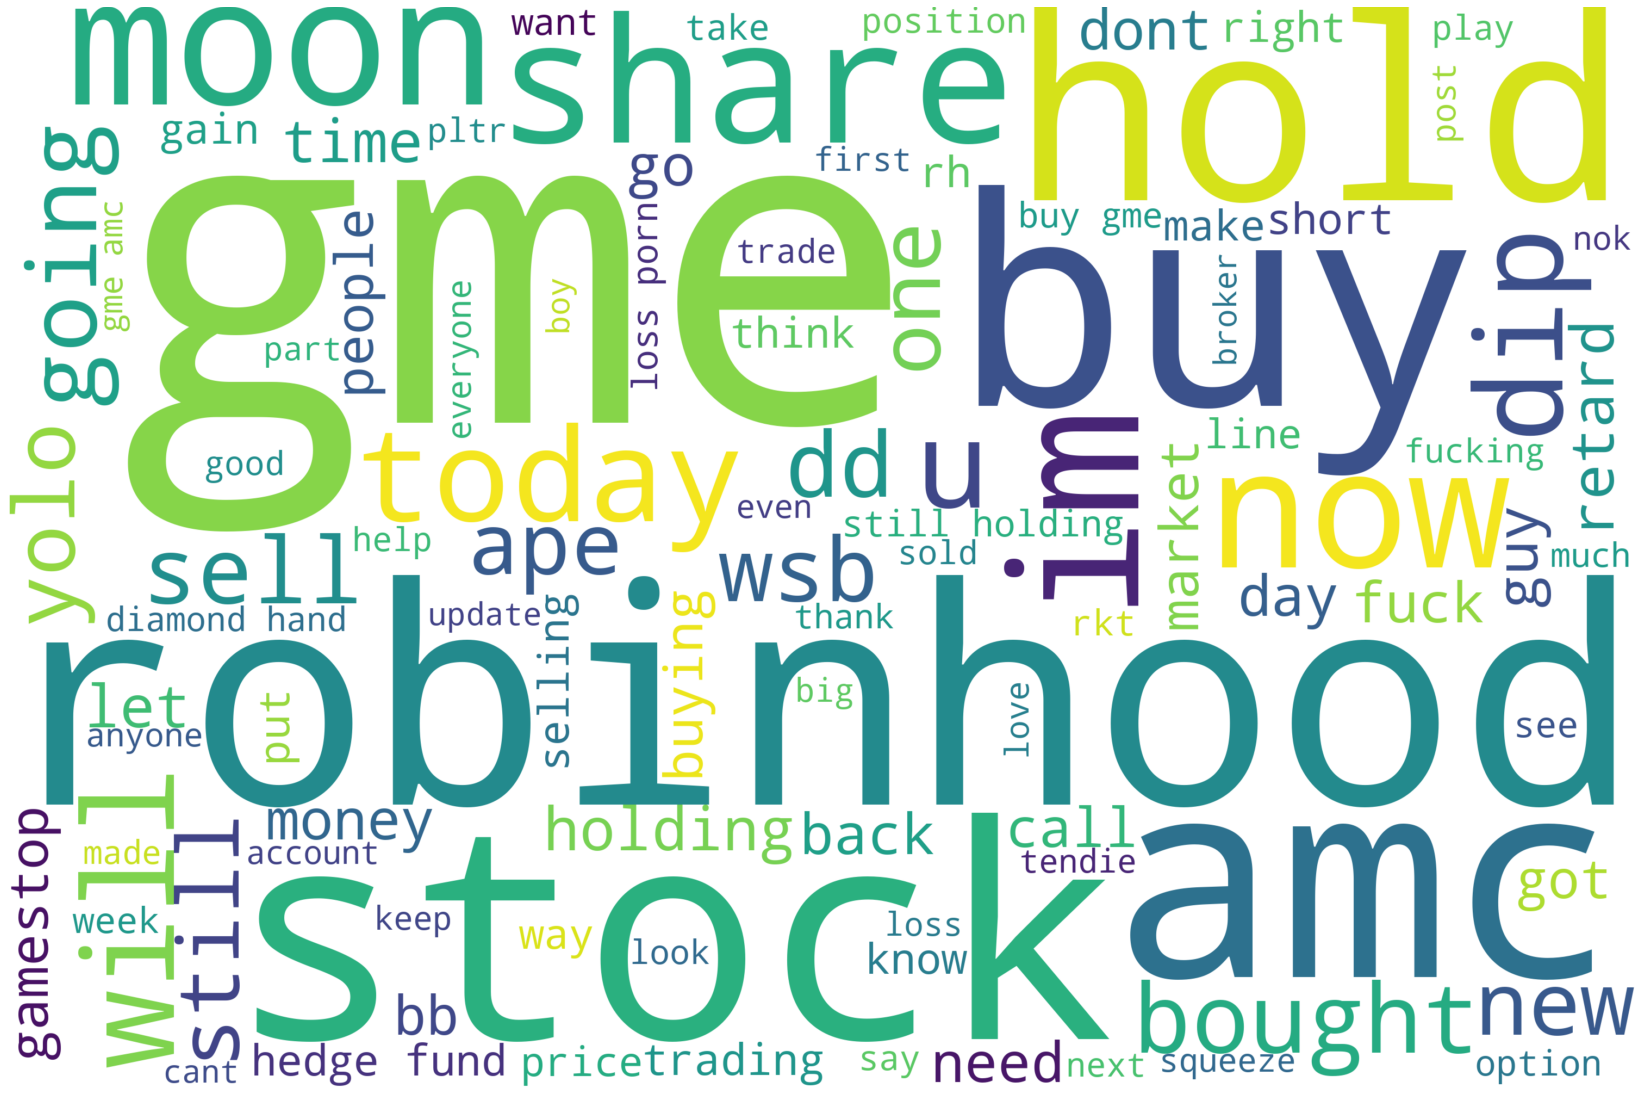

In [6]:
text = ' '.join(title for title in reddit['title'])

# Generates a word cloud image
wordcloud = WordCloud(width = 3000, height = 2000, background_color = 'white', 
                      max_words = 100, stopwords = STOPWORDS).generate(text)

# Displays the wordcloud image
plt.figure(figsize = (30,20))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()